# Portfolio Optimization with the use of Monte Carlo simulation and minimisation search

In [1]:
#!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
start ="2015-12-31"
end="2023-01-01"

In [3]:
ASIAN=yf.download("ASIANPAINT.NS",start,end)

C:\Users\kumar\anaconda3\Lib\site-packages\yfinance\base.py:196: UserWarning: Pandas requires version '2022.1' or newer of 'tzdata' (version '2021.1' currently installed).
  params_pretty[k] = str(_pd.Timestamp(params[k], unit='s').tz_localize("UTC").tz_convert(tz))


[*********************100%***********************]  1 of 1 completed


In [4]:
HINDUNILVR=yf.download("HINDUNILVR.NS",start,end)

[*********************100%***********************]  1 of 1 completed


In [5]:
ICICIBANK=yf.download("ICICIBANK.NS",start,end)

[*********************100%***********************]  1 of 1 completed


In [6]:
BHARTIARTL=yf.download("BHARTIARTL.NS",start,end)

[*********************100%***********************]  1 of 1 completed


In [7]:
ASIAN=ASIAN['Adj Close']
HINDUNILVR=HINDUNILVR['Adj Close']
ICICIBANK=ICICIBANK['Adj Close']
BHARTIARTL=BHARTIARTL['Adj Close']

<Axes: xlabel='Date'>

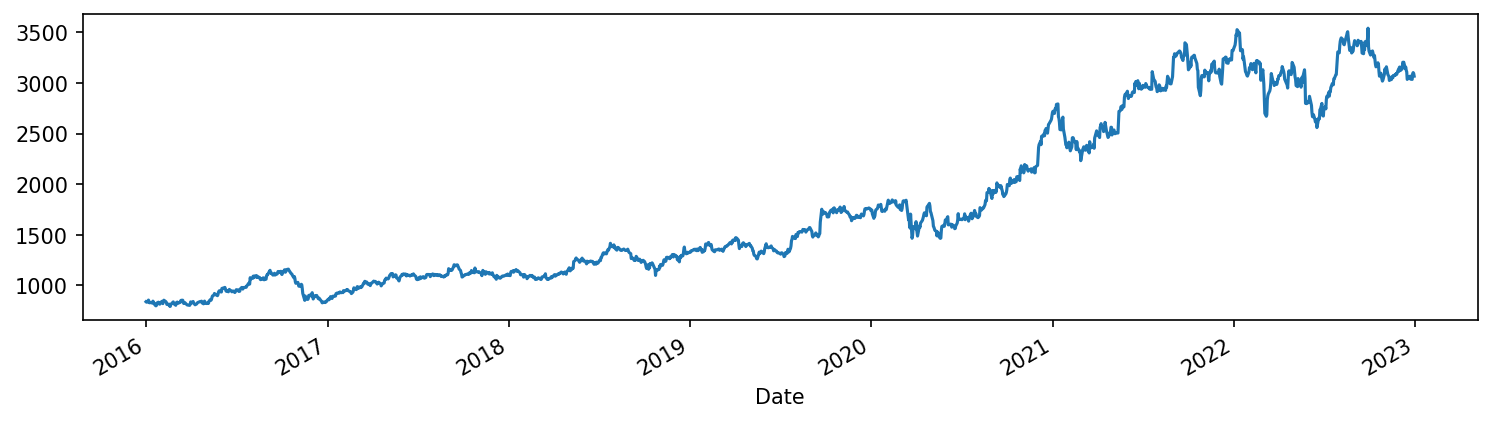

In [8]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
ASIAN.plot(figsize=(12,3))

<Axes: xlabel='Date'>

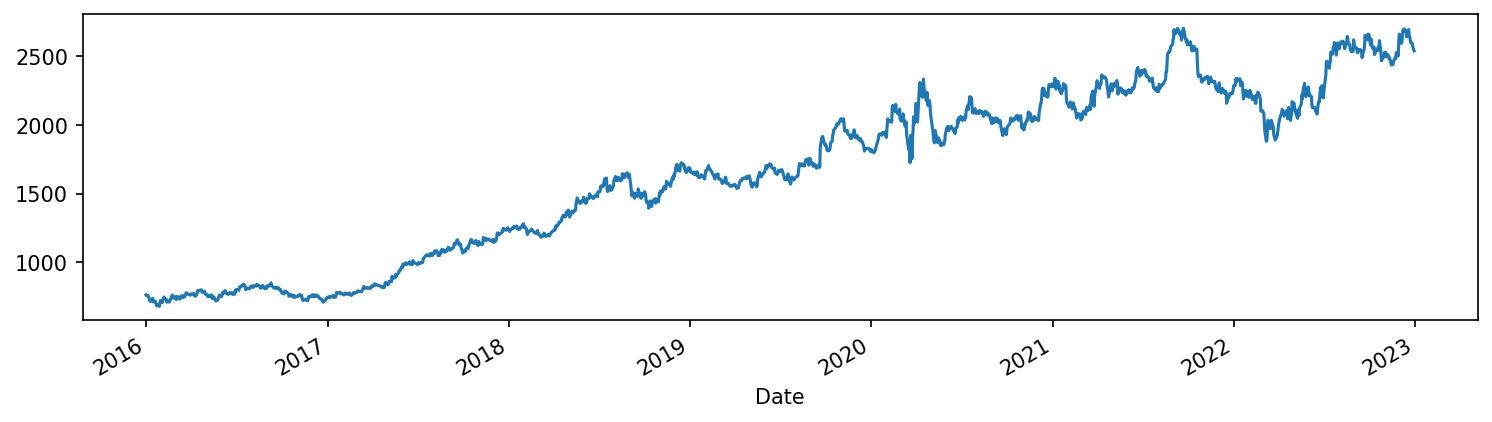

In [9]:
plt.figure(dpi=150)
HINDUNILVR.plot(figsize=(12,3))

<Axes: xlabel='Date'>

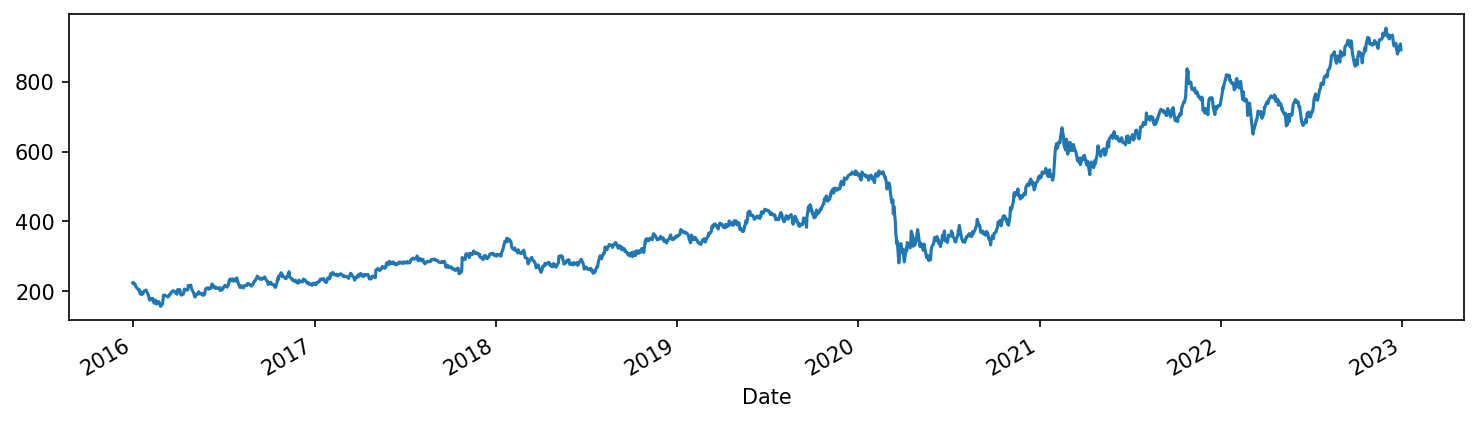

In [10]:
plt.figure(dpi=150)
ICICIBANK.plot(figsize=(12,3))

<Axes: xlabel='Date'>

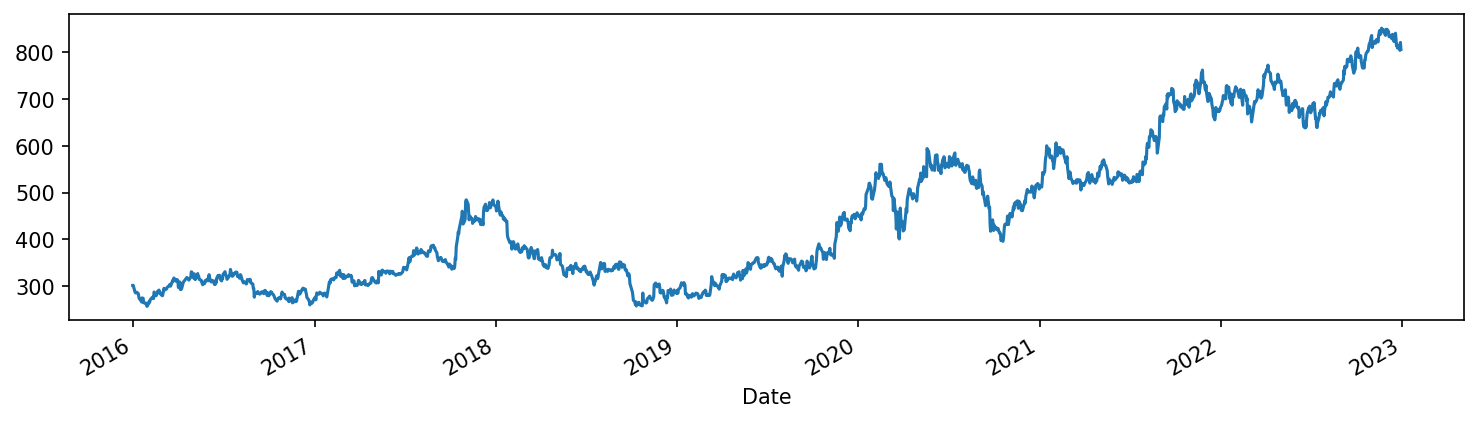

In [11]:
plt.figure(dpi=150)
BHARTIARTL.plot(figsize=(12,3))

## Creating a DataFrame named port conatining adjusted price of all four stocks

In [12]:
port = pd.concat([ASIAN,HINDUNILVR,ICICIBANK,BHARTIARTL],axis=1)
# Make sure to rename columns rather than just all "adjusted close"
port.columns = ['ASIAN','HINDUNILVR','ICICIBANK','BHARTIARTL']

In [13]:
# creating return as in absolute term it is very misleading which stocks perform better
port_rets=port.pct_change(1).dropna()

#### Why use Log Returns?

As we know, the benefit of using returns, versus prices, is **normalization**: allowing us to measure all variables in a comparable metric, thus enabling evaluation of analytic relationships amongst two or more variables despite originating from price series of unequal values. 

When considering the best weighting,we will only look at mean and variance, which means we are assuming a normal distribution of returns. But how can we get these, **log-normality**: if we assume that prices are distributed log normally (which, in practice, may or may not be true for any given price series), then **log(1 + r_i)** is normally distributed!

In [14]:
log_rets = np.log(port/port.shift(1))

In [15]:
log_rets=log_rets.dropna()

In [16]:
N = len(port.columns)

weights = np.random.random(N)

In [17]:
def gen_weights(N):
    weights = np.random.random(N)
    return weights/ np.sum(weights)

In [18]:
def calculate_returns(weights,log_rets):
    return np.sum(log_rets.mean()*weights) * 252 #Annualized Returns

In [19]:
log_rets.cov()

,ASIAN,HINDUNILVR,ICICIBANK,BHARTIARTL
ASIAN,0.000269,0.000101,0.000108,0.000078
HINDUNILVR,0.000101,0.000210,0.000083,0.000063
ICICIBANK,0.000108,0.000083,0.000466,0.000131
BHARTIARTL,0.000078,0.000063,0.000131,0.000409


In [20]:
log_rets_cov = log_rets.cov()

#### Portfolio Volatility (Variance) Function

https://www.investopedia.com/terms/p/portfolio-variance.asp

In [21]:
def calculate_volatility(weights,log_rets_cov):
    annualized_cov = np.dot(log_rets_cov*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

In [22]:
calculate_volatility(weights,log_rets_cov)

0.22267231318368585

In [23]:
mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []
for sim in range(6000):
    # This may take awhile!
    weights = gen_weights(N=4)
    mc_weights.append(weights)
    mc_portfolio_returns.append(calculate_returns(weights,log_rets))
    mc_portfolio_vol.append(calculate_volatility(weights,log_rets_cov))

In [24]:
mc_sharpe_ratios = np.array(mc_portfolio_returns)/np.array(mc_portfolio_vol)

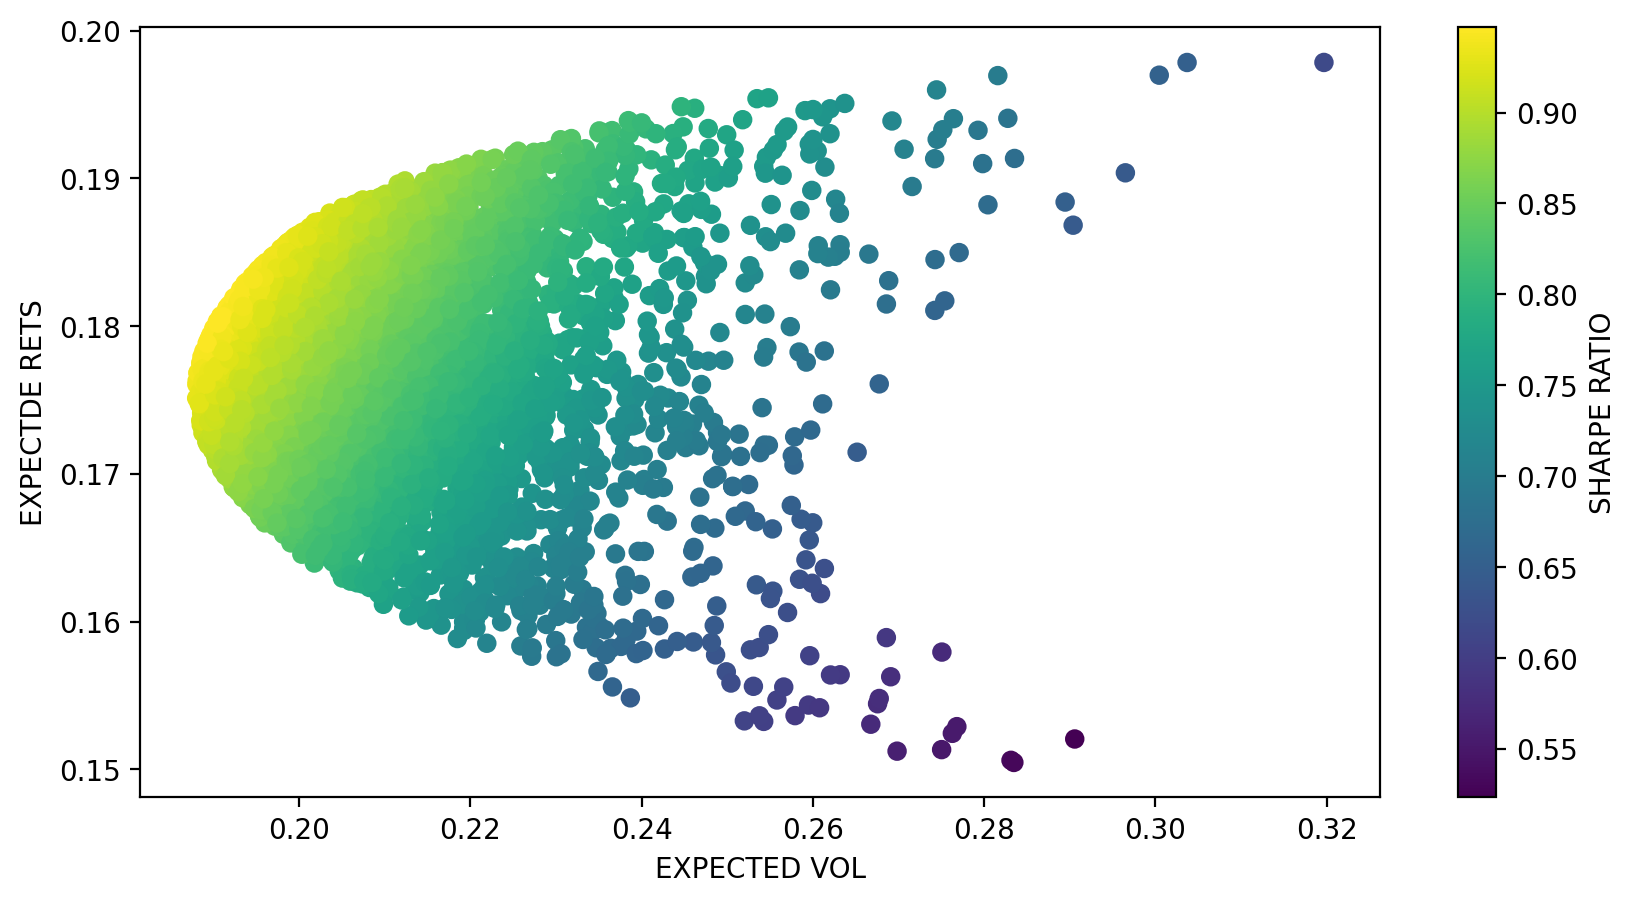

In [25]:
plt.figure(dpi=200,figsize=(10,5))
plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.ylabel('EXPECTDE RETS')
plt.xlabel('EXPECTED VOL')
plt.colorbar(label="SHARPE RATIO");

In [26]:
mc_weights[np.argmax(mc_sharpe_ratios)]

array([0.30877499, 0.42534313, 0.16160021, 0.10428168])

In [27]:
equal_weights = N * [1/N] 

In [28]:
from scipy.optimize import minimize

In [29]:
def function_to_minimize(weights):
    # Note -1* because we need to minimize this
    # Its the same as maximizing the positive sharpe ratio
    return -1 * (calculate_returns(weights,log_rets)/calculate_volatility(weights,log_rets_cov))

In [30]:
bounds = tuple((0,1) for n in range(N))

In [31]:
# Need to constrain all weights to add up to 1
sum_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})

In [32]:
optim=minimize(fun=function_to_minimize,x0=equal_weights,bounds=bounds,constraints=sum_constraint)

In [33]:
expected_returns_range = np.linspace(0.15,0.20,100)

In [34]:
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1},
               {'type':'eq','fun': lambda weights: calculate_returns(weights,log_rets) - possible_return})

In [35]:
def calculate_volatility(weights):
    annualized_cov = np.dot(log_rets_cov*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

In [36]:
frontier_volatility = []

for possible_return in expected_returns_range:
    # function for return
    
    
    result = minimize(calculate_volatility,equal_weights,bounds=bounds,constraints=constraints)
    
    frontier_volatility.append(result['fun'])

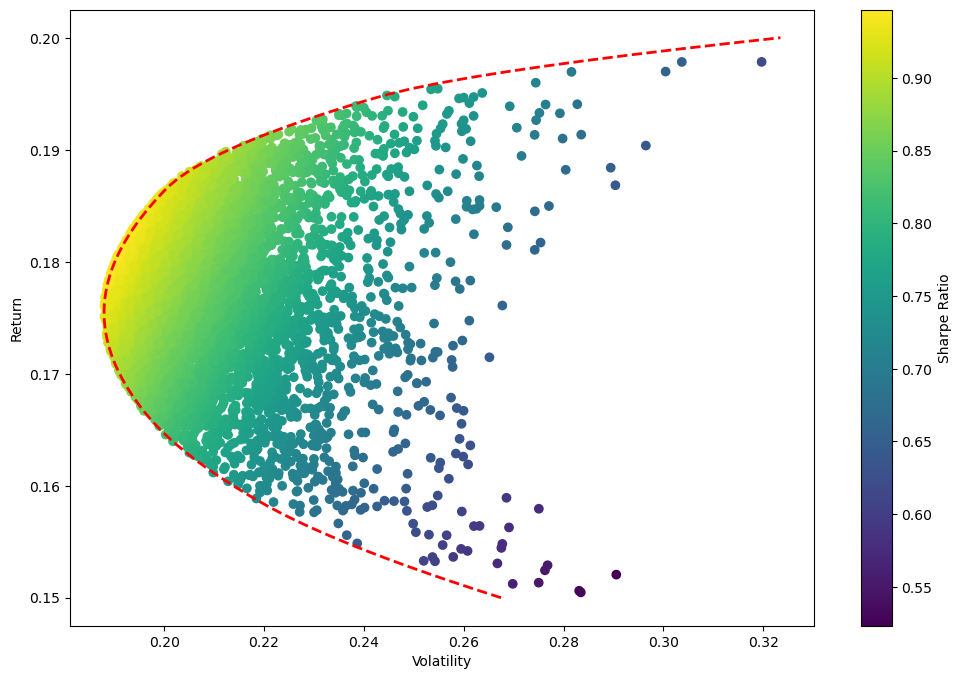

In [37]:
plt.figure(figsize=(12,8))
plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add frontier line
plt.plot(frontier_volatility,expected_returns_range,'r--',linewidth=2)

In [38]:
new_weights=optim.x

In [39]:
port_returns = np.dot(new_weights,port_rets.transpose())

In [40]:
cum_port_returns =   (1 + port_returns).cumprod() - 1

In [41]:
cum_port_returns_perc = pd.Series(100 * cum_port_returns)
cum_port_returns_perc.index = log_rets.dropna().index

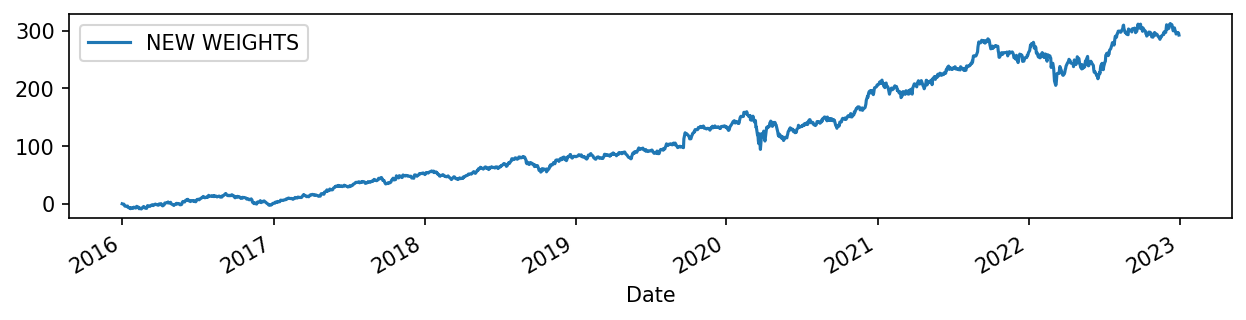

In [42]:
plt.figure(dpi=150)

cum_port_returns_perc.plot(figsize=(10,2),label='NEW WEIGHTS')
plt.legend()

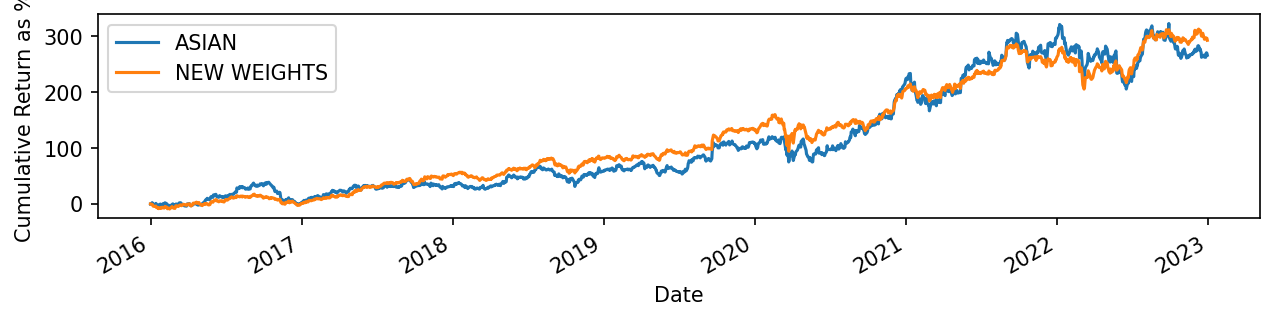

In [43]:
port_return = port.pct_change(1).dropna()
cumul_return = (1 + port_return['ASIAN']).cumprod() - 1
cumul_return_perc = cumul_return*100
plt.figure(dpi=150)
cumul_return_perc.plot(figsize=(12,3))
plt.ylabel("Cumulative Return as %")


cum_port_returns_perc.plot(figsize=(10,2),label='NEW WEIGHTS')
plt.legend()

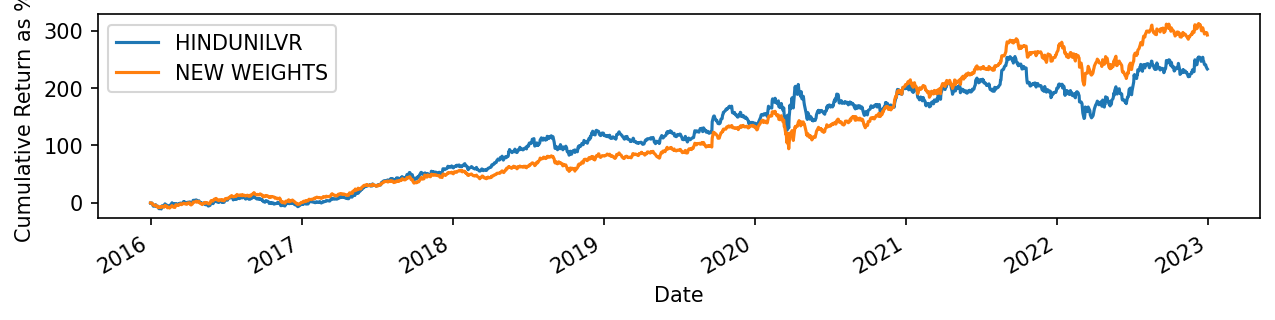

In [44]:
port_return = port.pct_change(1).dropna()
cumul_return = (1 + port_return['HINDUNILVR']).cumprod() - 1
cumul_return_perc = cumul_return*100
plt.figure(dpi=150)
cumul_return_perc.plot(figsize=(12,3))
plt.ylabel("Cumulative Return as %")


cum_port_returns_perc.plot(figsize=(10,2),label='NEW WEIGHTS')
plt.legend()

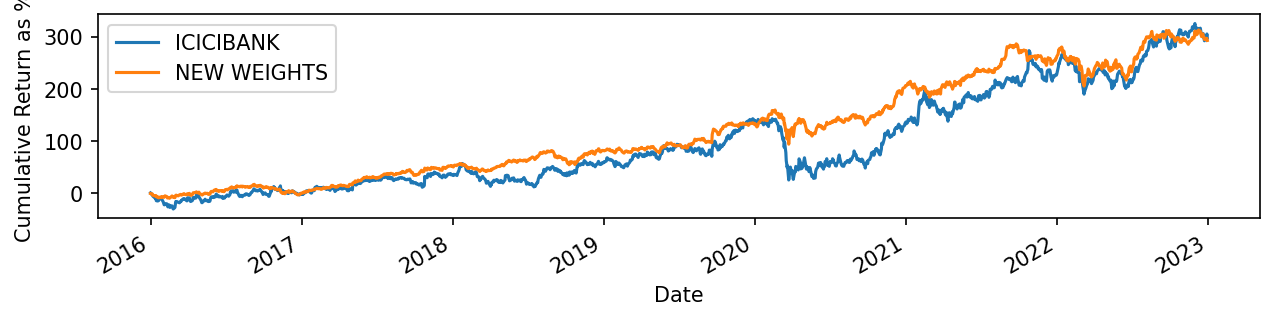

In [45]:
port_return = port.pct_change(1).dropna()
cumul_return = (1 + port_return['ICICIBANK']).cumprod() - 1
cumul_return_perc = cumul_return*100
plt.figure(dpi=150)
cumul_return_perc.plot(figsize=(12,3))
plt.ylabel("Cumulative Return as %")


cum_port_returns_perc.plot(figsize=(10,2),label='NEW WEIGHTS')
plt.legend()

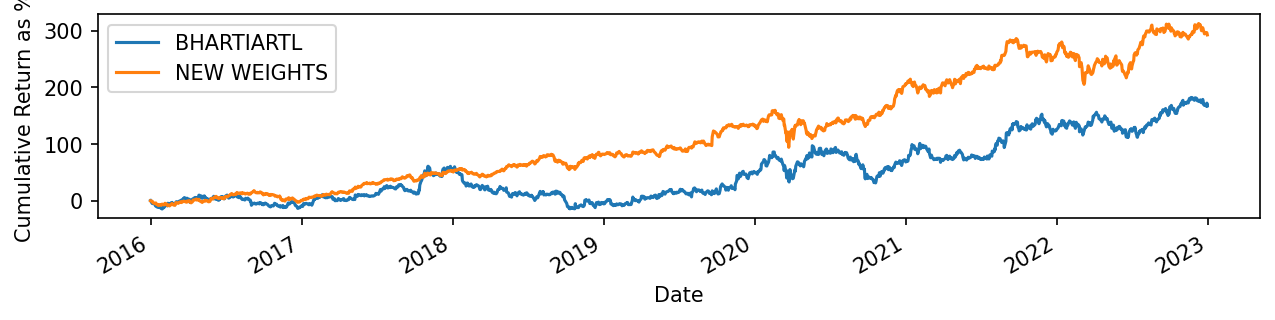

In [46]:
port_return = port.pct_change(1).dropna()
cumul_return = (1 + port_return['BHARTIARTL']).cumprod() - 1
cumul_return_perc = cumul_return*100
plt.figure(dpi=150)
cumul_return_perc.plot(figsize=(12,3))
plt.ylabel("Cumulative Return as %")


cum_port_returns_perc.plot(figsize=(10,2),label='NEW WEIGHTS')
plt.legend()

In [47]:
SENSEX=yf.download("^BSESN",start,end)

[*********************100%***********************]  1 of 1 completed


In [48]:
SENSEX=SENSEX['Adj Close'].pct_change(1).dropna()

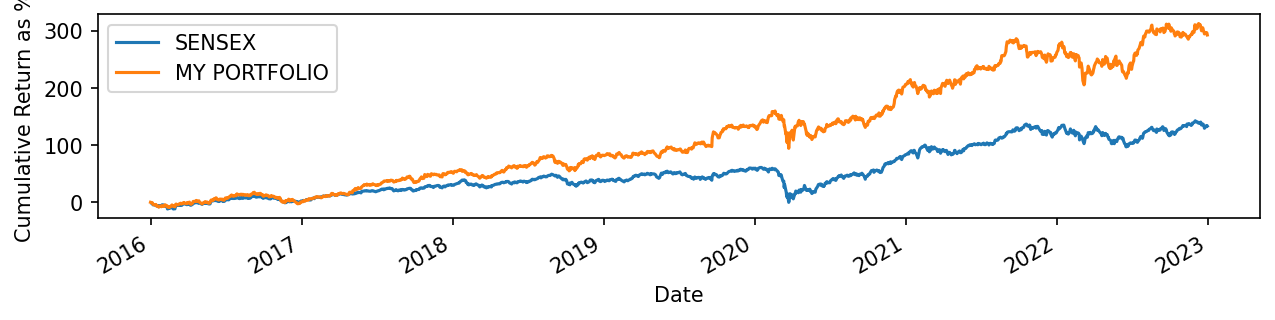

In [49]:

cumul_return = (1 + SENSEX).cumprod() - 1
cumul_return_perc = cumul_return*100
plt.figure(dpi=150)
cumul_return_perc.plot(figsize=(12,3),label='SENSEX')
plt.ylabel("Cumulative Return as %")


cum_port_returns_perc.plot(figsize=(10,2),label='MY PORTFOLIO')
plt.legend()

#### As we can see from this graph that My portfolio beats sensex for over 6 years consistantly
